In [1]:
%load_ext autoreload
%autoreload 2

# Imports


In [2]:

from bioreaction.simulation.manager import simulate_steady_states
from functools import partial
from typing import Optional, Tuple, List
from datetime import datetime
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.70"

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [3]:
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.evolution.mutation import implement_mutation, apply_mutation_to_sequence, get_mutation_type_mapping, reverse_mut_mapping
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.writer import DataWriter
from synbio_morpher.srv.io.loaders.circuit_loader import load_circuit
from synbio_morpher.srv.io.manage.script_manager import script_preamble

# Find good starting circuits


## Load data


In [4]:
og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data['mutation_type'] = data['mutation_type'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])
data['mutation_positions'] = data['mutation_positions'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])

### Modify original config file for running the sim

In [5]:
config = load_json_as_dict(os.path.join(fn.split('summarise')[
                           0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'
config['simulation']['device'] = 'gpu'

jax.devices()

xla_bridge.py:backends():622: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter INFO
xla_bridge.py:backends():622: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO


[gpu(id=0)]

## Select starting candidates

We want to start with a circuit that has high adaptability, so a circuit that has high signal sensitivity and precision. We'll use the non-signal species $RNA_1$ and $RNA_2$ as the outputs.

One thing to look out for is that because precision is often then inverse of sensitivity, it will be much larger typically, so selecting the largest for both should give preference to sensitivity.


In [6]:
signal_species = config['signal']['inputs']

filt = (
    (data[get_true_interaction_cols(data, 'energies')].sum(axis=1) != 0) &
    (data['sample_name'].isin(signal_species) != True) &
    (data['overshoot'] > 0)
)

percentile = 0.9
sensitivity_range = data[filt]['sensitivity_wrt_species-6'] > (data[filt]['sensitivity_wrt_species-6'].max() *
                                                               percentile)
starting_circ_rows = data[filt][sensitivity_range].sort_values(
    by=['sensitivity_wrt_species-6', 'precision_wrt_species-6'], ascending=False)

print(
    f'Picking circuits that have a sensitivity in the {percentile * 100}th percentile of at least {data[filt]["sensitivity_wrt_species-6"].max() * percentile}')

len(starting_circ_rows)

Picking circuits that have a sensitivity in the 90.0th percentile of at least 0.36505494


13

Plot the starting candidates.

In [7]:
pause

NameError: name 'pause' is not defined

Text(0, 0.5, 'Precision')

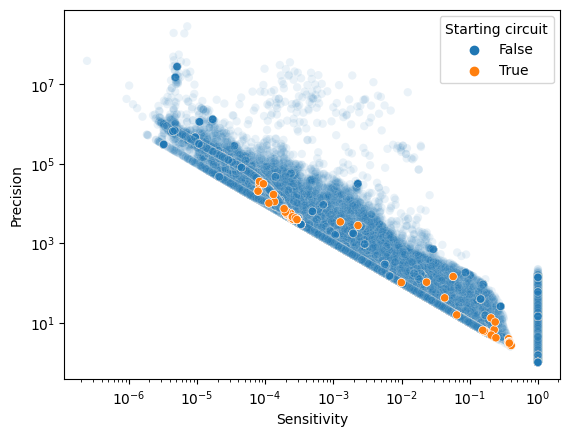

In [ ]:

data['Starting circuit'] = (data['circuit_name'].isin(starting_circ_rows['circuit_name'])) & \
    (data['mutation_name'].isin(starting_circ_rows['mutation_name'])) & filt

sns.scatterplot(
    data.sort_values(by='Starting circuit'), x='sensitivity_wrt_species-6', y='precision_wrt_species-6',
    hue='Starting circuit', alpha=((data.sort_values(by='Starting circuit')['Starting circuit'] + 0.1)/1.1)
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')

# Monte Carlo optimisation

We want to push circuits into ranges of higher sensitivity


## Optimisation function


In [32]:
def mag(vec, **kwargs):
    return jnp.linalg.norm(vec, **kwargs)


def vec_distance(s, p, d):
    """ First row of each direction vector are the x's, second row are the y's """
    P = jnp.array([s, p]).T
    # P = [s.T, p.T]
    sp_rep = np.repeat(d[:, 0][:, None], repeats=len(s), axis=-1).T[:, :, None]
    AP = jnp.concatenate([sp_rep, P[:, :, None]], axis=-1)
    area = mag(jnp.cross(AP, d[None, :, :], axis=-1), axis=-1)
    D = area / mag(d)
    return D
    

def make_distance_func(data):
    sp_min = data[(
        data['sensitivity_wrt_species-6'] <= 1/data['precision_wrt_species-6']) | (
            data['precision_wrt_species-6'] <= 1/data['sensitivity_wrt_species-6'])][['sensitivity_wrt_species-6', 'precision_wrt_species-6']].min().to_numpy()
    sp_max = data[(
        data['sensitivity_wrt_species-6'] <= 1/data['precision_wrt_species-6']) | (
            data['precision_wrt_species-6'] <= 1/data['sensitivity_wrt_species-6'])][['sensitivity_wrt_species-6', 'precision_wrt_species-6']].max().to_numpy()
    sp_left = np.array([sp_min[0], sp_max[1]])
    sp_right = np.array([sp_max[0], sp_min[1]])

    d = np.array([sp_left, sp_right]).T
    return partial(vec_distance, d=d)


def sp_prod(s, p, sp_factor=1, s_weight=0):
    """ Log product of s and p """
    s_lin = 1/p
    return s * (p * (s - s_lin)) # * sp_factor + s_weight)


def log_distance(s, p):
    lin = np.array([np.logspace(6, -3, 2), np.logspace(-6, 3, 2)])
    return vec_distance(s, p, lin)


## Selection schemes

/tmp/ipykernel_726/420641705.py:32: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(
/tmp/ipykernel_726/420641705.py:50: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(log_distance(s=s, p=p) * sp_prod(
/tmp/ipykernel_726/420641705.py:59: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(log_distance(s=s, p=p) * np.log(sp_prod(
/tmp/ipykernel_726/420641705.py:76: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), 1) * sp_prod(s=s, p=p))) #, palette='viridis_r')


Text(0.5, 1.0, 'Log: Combined simple sp product and log distance')

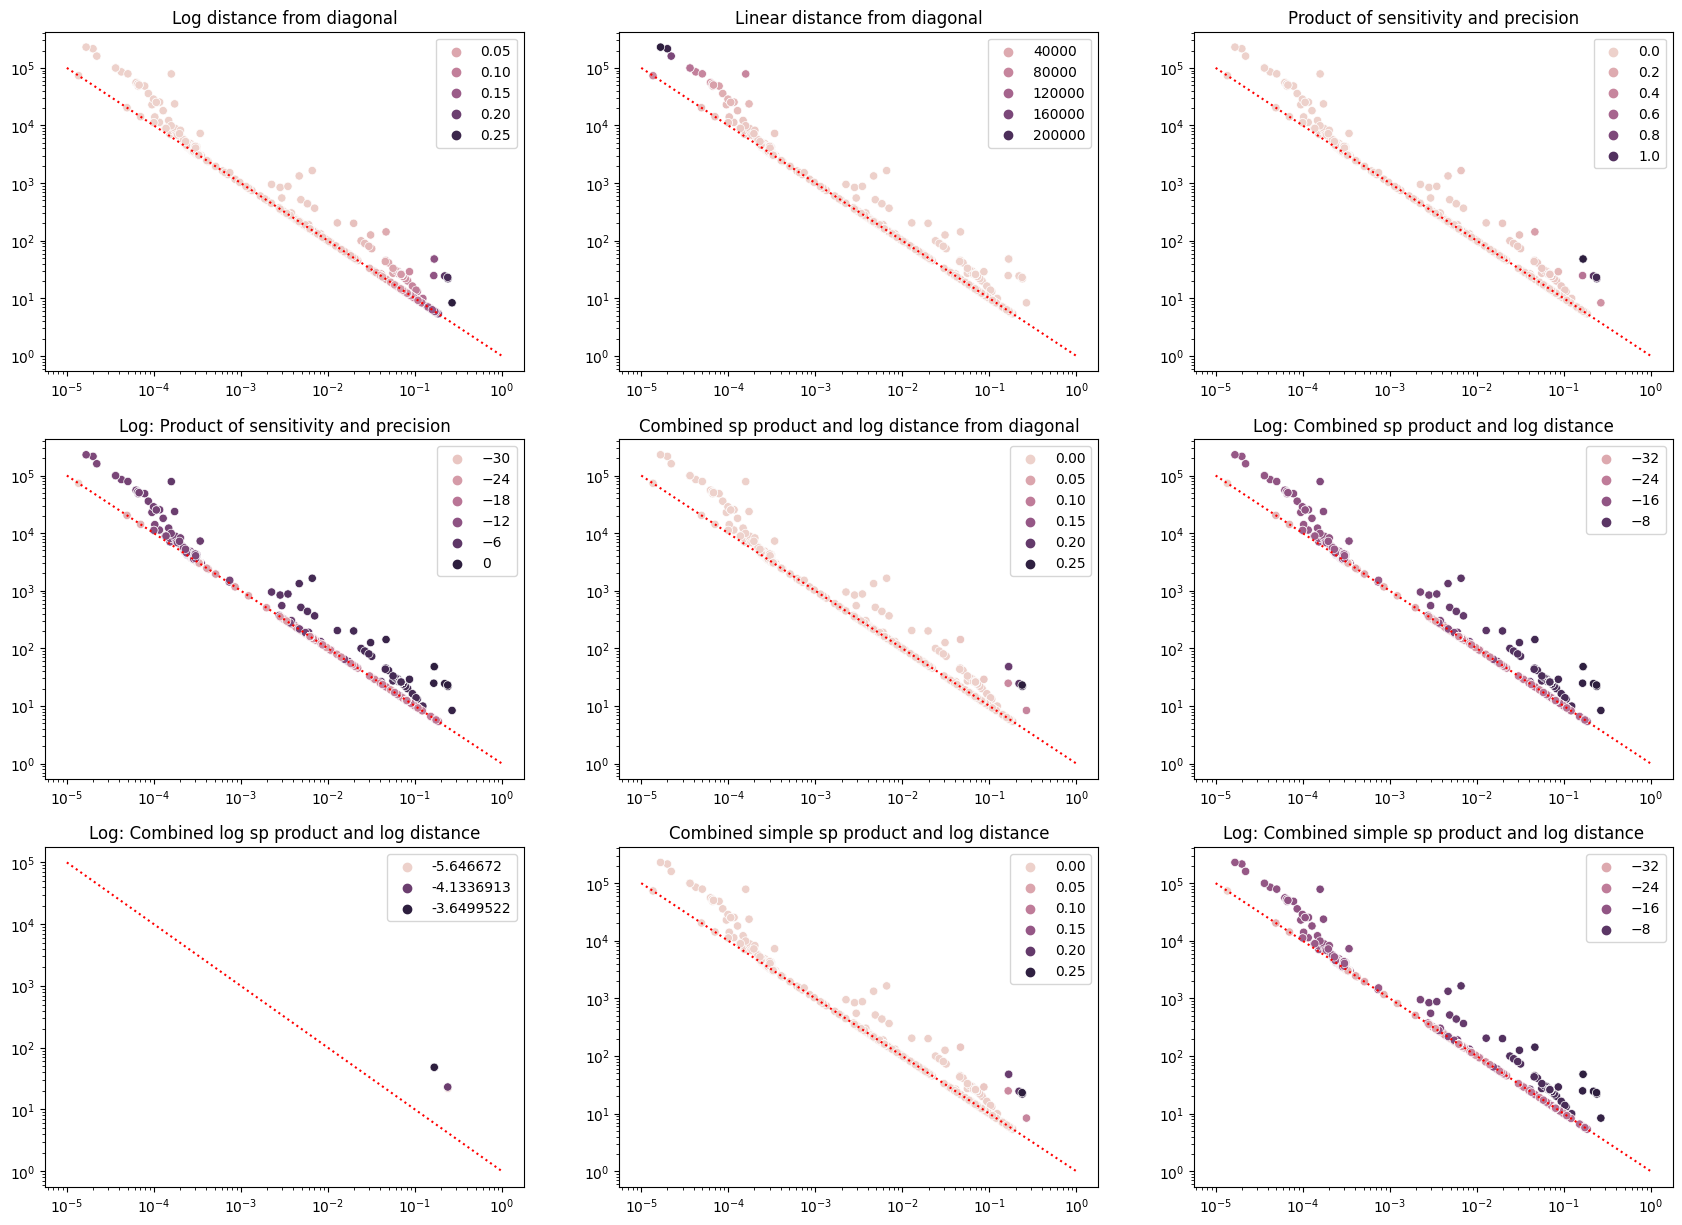

In [ ]:
choose = 2500
s = data[data['sample_name'] != 'RNA_0']['sensitivity_wrt_species-6'].iloc[:choose].to_numpy()
p = data[data['sample_name'] != 'RNA_0']['precision_wrt_species-6'].iloc[:choose].to_numpy()

fig = plt.figure(figsize=(7*3, 5*3))

ax = plt.subplot(3,3,1)
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=log_distance(s=s, p=p)) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Log distance from diagonal')

ax = plt.subplot(3,3,2)
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=make_distance_func(data)(s=s, p=p)) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Linear distance from diagonal')

ax = plt.subplot(3,3,3)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p)) #, sp_factor=(p / s).max(), s_weight=(np.log(p) / (s)))) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Product of sensitivity and precision')

ax = plt.subplot(3,3,4)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=np.log(
    sp_prod(s=s, p=p, sp_factor=(p / s).max(), s_weight=(np.log(p) / (s))))) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Log: Product of sensitivity and precision')

ax = plt.subplot(3,3,5)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=log_distance(s=s, p=p) * sp_prod(
    s=s, p=p, sp_factor=(p / s).max(), s_weight=(np.log(p) / (s)))) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Combined sp product and log distance from diagonal')

ax = plt.subplot(3,3,6)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=np.log(log_distance(s=s, p=p) * sp_prod(
    s=s, p=p, sp_factor=(p / s).max(), s_weight=(np.log(p) / (s))))) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Log: Combined sp product and log distance')

ax = plt.subplot(3,3,7)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=np.log(log_distance(s=s, p=p) * np.log(sp_prod(
    s=s, p=p, sp_factor=(p / s).max(), s_weight=(np.log(p) / (s)))))) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Log: Combined log sp product and log distance')

ax = plt.subplot(3,3,8)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=log_distance(s=s, p=p) * sp_prod(s=s, p=p)) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Combined simple sp product and log distance')

ax = plt.subplot(3,3,9)
# sns.scatterplot(x=s, y=p, hue=sp_prod(s=s, p=p, sp_factor=(np.log(p) / (s)), s_weight=(p / s).max())) #, palette='viridis_r')
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), 1) * sp_prod(s=s, p=p))) #, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.title('Log: Combined simple sp product and log distance')


The bias towards higher sensitivities is essentially controlled by the log distance to the diagonal in a roundabout way - large precision values tend to be further from the diagonal even just from differences in solver steps. 

The power to which the log distance from the diagonal is raised can control the bias, as demonstrated below on a series of exponentials. Power values approaching 0 tend to bias towards an optimisation function that solely optimises in the +x and +y direction.

/tmp/ipykernel_726/2815889997.py:7: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
/tmp/ipykernel_726/2815889997.py:15: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
/tmp/ipykernel_726/2815889997.py:23: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
/tmp/ipykernel_726/2815889997.py:31: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
/tmp/ipykernel_726/2815889997.py:39: RuntimeWarning: invalid value encountered in log
  sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=

Text(0.5, 1.0, 'Combined sp product and log distance: pow = 3')

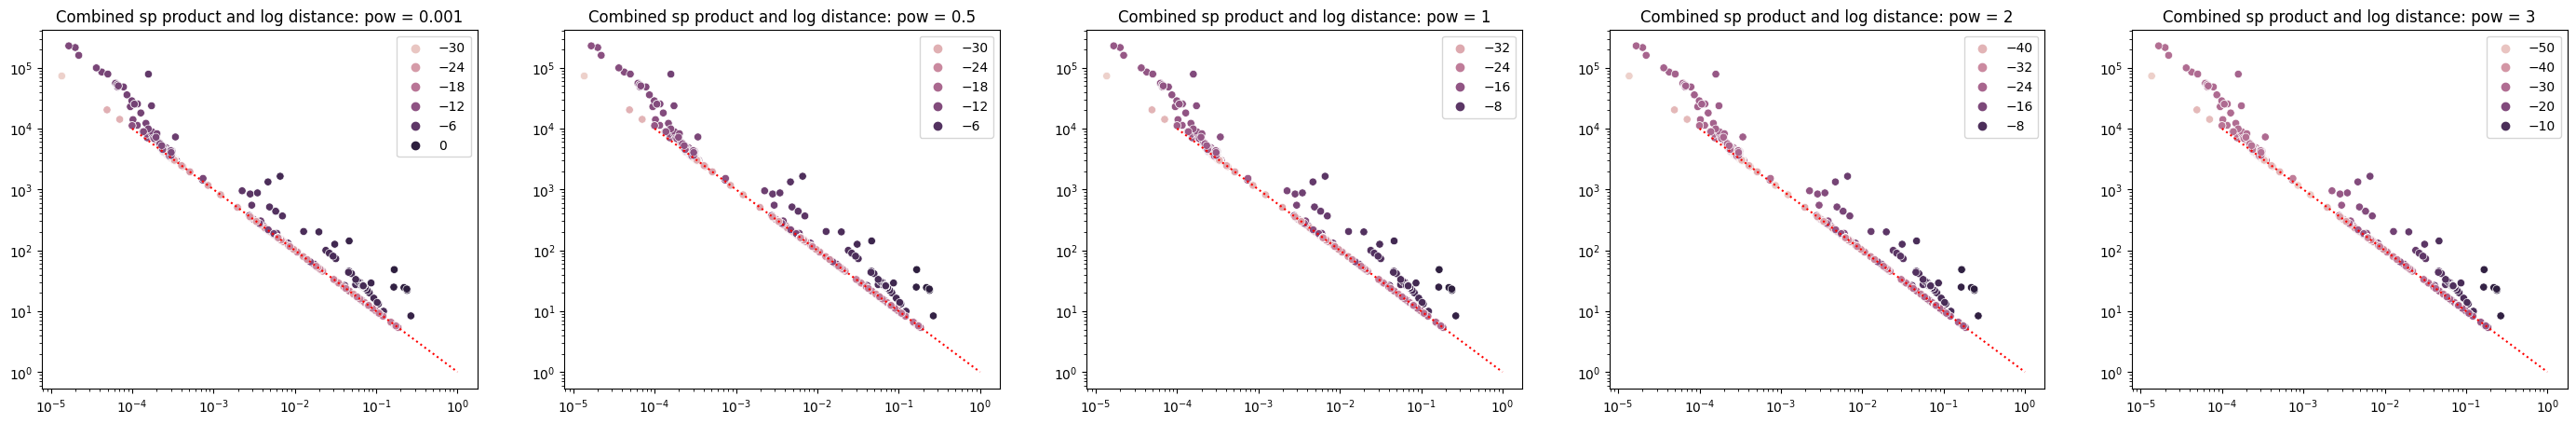

In [ ]:
pows = [0.001, 0.5, 1, 2, 3]

fit = plt.figure(figsize=(5*7, 5))

i = 0
ax = plt.subplot(1,5,i+1)
sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Combined sp product and log distance: pow = {pows[i]}')

i += 1
ax = plt.subplot(1,5,i+1)
sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Combined sp product and log distance: pow = {pows[i]}')

i += 1
ax = plt.subplot(1,5,i+1)
sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Combined sp product and log distance: pow = {pows[i]}')

i += 1
ax = plt.subplot(1,5,i+1)
sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Combined sp product and log distance: pow = {pows[i]}')

i += 1
ax = plt.subplot(1,5,i+1)
sns.scatterplot(x=s, y=p, hue=np.log(np.power(log_distance(s=s, p=p), pows[i]) * sp_prod(s=s, p=p))) #, palette='viridis_r')
plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Combined sp product and log distance: pow = {pows[i]}')


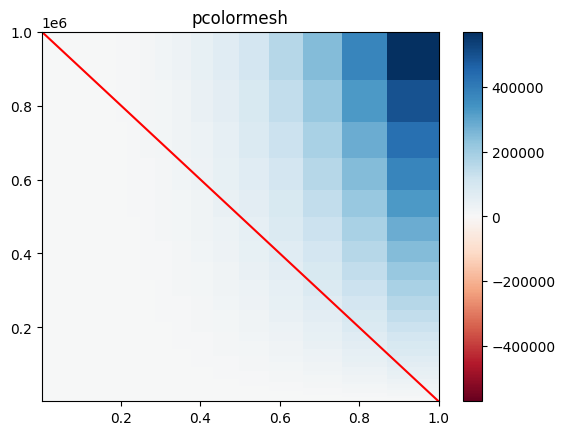

In [ ]:

s, p = np.meshgrid(np.logspace(-6, 0, 100), np.logspace(0, 6, 100))

# z = np.log(np.power(jax.vmap(log_distance)(s=s, p=p), 0.1) * sp_prod(s=s, p=p))
z = jax.vmap(log_distance)(s=s, p=p) * sp_prod(s=s, p=p)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(s, p, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
ax.axis([s.min(), s.max(), p.min(), p.max()])
fig.colorbar(c, ax=ax)

plt.plot(np.logspace(-6, 0, 2), np.logspace(6, 0, 2), 'r')

plt.show()

The final graph (3,3) roughly matches the kind of selection scoring that we would be looking for the best. Therefore, the circuits will be scored according to the log distance from the diagonal multiplied by the product of sensitivity and precision.

## Optimisation loop


### Initialise and set up run

In [27]:
config['mutations_args'] = {
    'algorithm': 'random',
    'mutation_counts': 2,
    'mutation_nums_within_sequence': [1],
    'mutation_nums_per_position': 1,
    'concurrent_species_to_mutate': 'single_species_at_a_time',
    'seed': 0
}
config['simulation']['dt0'] = config['simulation']['dt']
config['simulation']['threshold_steady_states'] = 0.1
config['experiment']['no_numerical'] = False
config['experiment']['no_visualisations'] = True

In [28]:
config, data_writer = script_preamble(prepare_config(config))

modeller = CircuitModeller(data_writer, config)
evolver = Evolver(data_writer, mutation_type='random', sequence_type='RNA', seed=0)

### Sim funcs

In [29]:


def mutate(circuits: list, evolver: Evolver, algorithm: str = 'random'):
    
    for c in circuits:
        c = evolver.mutate(
            c, write_to_subsystem=True, algorithm=algorithm)

    return circuits


def simulate(circuits: list, modeller: CircuitModeller, config: dict) -> list:
    
    circuits = modeller.batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuits": {'batch': True},
            "simulate_signal_batch": {'ref_circuit': None,
                                      'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                              'no_numerical': config['experiment']['no_numerical']}
        }
    )
    
    return circuits

    

### Helper funcs

In [30]:


def load_all_analytics(circuit_dirs):
    """ Top (starting) directory should be the starting circuit for each round """
    
    fbn = 'report_signal.json'
    circuits = {}
    for circuit_dir in circuit_dirs:
        if 'mutations' in os.listdir(circuit_dir):
            circuits[os.path.basename(circuit_dir)] = load_all_analytics(
                [os.path.join(circuit_dir, sc) for sc in os.listdir(circuit_dir)]) 
            circuits[os.path.basename(circuit_dir)]['ref_circuit'] = load_json_as_dict(
                os.path.join(circuit_dir, fbn))
        else:
            circuits[os.path.basename(circuit_dir)] = load_json_as_dict(os.path.join(circuit_dir, fbn))
    return circuits

def make_next_name(name: str, subname: str):
    return name + '_' + subname
    # if subname == 'ref_circuit':
    #     return name
    # special_char = '_N_'
    # return name.split(special_char)[0] + special_char + ''.join(str(datetime.now()).replace('.', '').split(':')[1:])



### Choosing next circuit

In [33]:
def choose_next(batch: list, data_writer, distance_func, choose_max: int = 4, target_species: List[str] = ['RNA_1', 'RNA_2'], dist_weight=1):
    
    def make_data(batch, batch_analytics, target_species: List[str]):
        d = pd.DataFrame(
            data=np.concatenate(
                [
                    np.asarray([c.name for c in batch])[:, None],
                    np.asarray([c.subname for c in batch])[:, None]
                ], axis=1
            ),
            columns=['Name', 'Subname']
        )
        d['Circuit Obj'] = batch
        species_names = [s.name for s in batch[0].model.species]
        t_idxs = {s: species_names.index(s) for s in species_names if s in target_species}
        for t in target_species:
            t_idx = t_idxs[t]
            d[f'Sensitivity species-{t}'] = np.asarray([b['sensitivity_wrt_species-6'][t_idx] for b in batch_analytics])
            d[f'Precision species-{t}'] = np.asarray([b['precision_wrt_species-6'][t_idx] for b in batch_analytics])
            d[f'Overshoot species-{t}'] = np.asarray([b['overshoot'][t_idx] for b in batch_analytics])
            
            rs = d[d['Subname'] == 'ref_circuit']
            d[f'Parent Sensitivity species-{t}'] = jax.tree_util.tree_map(lambda n: rs[rs['Name'] == n][f'Sensitivity species-{t}'].iloc[0], d['Name'].to_list())
            d[f'Parent Precision species-{t}'] = jax.tree_util.tree_map(lambda n: rs[rs['Name'] == n][f'Precision species-{t}'].iloc[0], d['Name'].to_list())
        
            d[f'dS species-{t}'] = np.asarray([b['sensitivity_wrt_species-6_diff_to_base_circuit'][t_idx] for b in batch_analytics])
            d[f'dP species-{t}'] = np.asarray([b['precision_wrt_species-6_diff_to_base_circuit'][t_idx] for b in batch_analytics])
            # d[f'dS species-{t}'] = d[f'Sensitivity species-{t}'] - d[f'Parent Sensitivity species-{t}']
            # d[f'dP species-{t}'] = d[f'Precision species-{t}'] - d[f'Parent Precision species-{t}']
            
            # d[f'Diag Distance species-{t}'] = distance_func(s=d[f'Sensitivity species-{t}'].to_numpy(), p=d[f'Precision species-{t}'].to_numpy())
            d[f'SP Prod species-{t}'] = sp_prod(s=d[f'Sensitivity species-{t}'].to_numpy(), p=d[f'Precision species-{t}'].to_numpy(), 
                                                sp_factor=1, #(d[f'Precision species-{t}'] / d[f'Sensitivity species-{t}']).max(), 
                                                s_weight=0) #np.log(d[f'Precision species-{t}']) / d[f'Sensitivity species-{t}'])
            d[f'Log Distance species-{t}'] = np.array(log_distance(s=d[f'Sensitivity species-{t}'].to_numpy(), p=d[f'Precision species-{t}'].to_numpy()))
            # d[f'SP and distance species-{t}'] = np.log( np.power(d[f'Log Distance species-{t}'], dist_weight) * np.log(d[f'SP Prod species-{t}']))
            d[f'SP and distance species-{t}'] = d[f'SP Prod species-{t}'] * d[f'Log Distance species-{t}']
            
        return d
    
    def select_next(data_1, choose_max, t):
        # filt = (data_1[f'dS species-{t}'] >= 0) & (data_1[f'dP species-{t}'] >= 0) & (
        #     data_1[f'Sensitivity species-{t}'] >= data_1[data_1['Subname'] == 'ref_circuit'][f'Sensitivity species-{t}'].min()) & (
        #         data_1[f'Precision species-{t}'] >= data_1[data_1['Subname'] == 'ref_circuit'][f'Precision species-{t}'].min())
        
        circuits_chosen = data_1.sort_values(
            by=[f'SP and distance species-{t}', f'Log Distance species-{t}', f'SP Prod species-{t}', 'Name', 'Subname'], ascending=False)['Circuit Obj'].iloc[:choose_max].to_list()
        
        data_1['Next selected'] = data_1['Circuit Obj'].isin(circuits_chosen)
        return data_1, circuits_chosen
        
    def get_batch_analytics(batch, data_writer):
        batch_analytics = []
        for c in batch:
            if c.subname == 'ref_circuit':
                batch_analytics.append(
                    load_json_as_dict(os.path.join(data_writer.top_write_dir, c.name, 'report_signal.json')))
            else:
                batch_analytics.append(
                    load_json_as_dict(os.path.join(data_writer.top_write_dir, c.name, 'mutations', c.subname, 'report_signal.json'))
                )
        batch_analytics = jax.tree_util.tree_map(lambda x: np.float64(x), batch_analytics)
        return batch_analytics
    
    batch_analytics = get_batch_analytics(batch, data_writer)
    data_1 = make_data(batch, batch_analytics, target_species)
    
    t = target_species[0]
    # circuits_chosen = data_1[(data_1[f'dS species-{t}'] >= 0) & (data_1[f'dP species-{t}'] >= 0)].sort_values(by=[f'Sensitivity species-{t}', f'Precision species-{t}'], ascending=False)['Circuit Obj'].iloc[:choose_max].to_list()
    data_1, circuits_chosen = select_next(data_1, choose_max, t)
    return circuits_chosen, data_1


In [ ]:
sdata0 = summary_datas[0]
sdata1 = summary_datas[1]

t = 'RNA_1'
circuits_chosen = sdata0[
    (sdata0[f'dS species-{t}'] >= 0) & 
    (sdata0[f'dP species-{t}'] >= 0) &
    (sdata0[f'Sensitivity species-{t}'] >= sdata0[sdata0['Subname'] == 'ref_circuit'][f'Sensitivity species-{t}'].min()) &
    (sdata0[f'Precision species-{t}'] >= sdata0[sdata0['Subname'] == 'ref_circuit'][f'Precision species-{t}'].min())].sort_values(
        by=[f'SP and distance species-{t}', f'Log Distance species-{t}', f'SP Prod species-{t}', 'Name', 'Subname'], ascending=False)['Circuit Obj'].iloc[:choose_max].to_list()
# sdata0[sdata0['Circuit Obj'].isin(circuits_chosen)]
sdata0[sdata0['Next selected']].sort_values(by=['Name', "Subname"])

,Name,Subname,Circuit Obj,Sensitivity species-RNA_1,Precision species-RNA_1,Overshoot species-RNA_1,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,...,Precision species-RNA_2,Overshoot species-RNA_2,Parent Sensitivity species-RNA_2,Parent Precision species-RNA_2,dS species-RNA_2,dP species-RNA_2,SP Prod species-RNA_2,Log Distance species-RNA_2,SP and distance species-RNA_2,Next selected
9,toy_mRNA_circuit_10622_RNA_0_m5-9,RNA_0_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.387184,2.764984,0.153422,0.387113,2.763281,0.000071,0.001704,...,3302.0490,0.000000,0.000303,3304.9487,2.657180e-07,-2.899658,-73.749539,0.000697,NaN,True
12,toy_mRNA_circuit_10622_RNA_0_m5-9,RNA_2_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.387113,2.763281,0.152173,0.387113,2.763281,0.000000,0.000000,...,3304.9487,0.000000,0.000303,3304.9487,0.000000e+00,0.000000,-73.764641,0.000697,NaN,True
13,toy_mRNA_circuit_10622_RNA_0_m5-9,RNA_2_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.387113,2.763281,0.152173,0.387113,2.763281,0.000000,0.000000,...,3304.9487,0.000000,0.000303,3304.9487,0.000000e+00,0.000000,-73.764641,0.000697,NaN,True
7,toy_mRNA_circuit_10622_RNA_0_m5-9,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.387113,2.763281,0.152173,0.387113,2.763281,0.000000,0.000000,...,3304.9487,0.000000,0.000303,3304.9487,0.000000e+00,0.000000,-73.764641,0.000697,NaN,True
49,toy_mRNA_circuit_11088_RNA_1_m3-5,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.378497,3.075854,0.287637,0.378497,3.075854,0.000000,0.000000,...,5178.6640,0.012268,0.000276,5178.6640,0.000000e+00,0.000000,-78.284053,0.000724,NaN,True
47,toy_mRNA_circuit_11227_RNA_0_m2-4,RNA_2_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.379453,2.958583,0.198762,0.379453,2.958583,0.000000,0.000000,...,3162.1448,0.000000,0.000316,3162.1448,0.000000e+00,0.000000,-73.006580,0.000684,NaN,True
42,toy_mRNA_circuit_11227_RNA_0_m2-4,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.379453,2.958583,0.198762,0.379453,2.958583,0.000000,0.000000,...,3162.1448,0.000000,0.000316,3162.1448,0.000000e+00,0.000000,-73.006580,0.000684,NaN,True
33,toy_mRNA_circuit_11718_RNA_1_m10-7,RNA_2_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.380777,2.975924,0.232631,0.380777,2.975924,0.000000,0.000000,...,3191.6108,0.000000,0.000313,3191.6108,0.000000e+00,0.000000,-73.165439,0.000687,NaN,True
34,toy_mRNA_circuit_11718_RNA_1_m10-7,RNA_2_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.380777,2.975924,0.232631,0.380777,2.975924,0.000000,0.000000,...,3191.6108,0.000000,0.000313,3191.6108,0.000000e+00,0.000000,-73.165439,0.000687,NaN,True
28,toy_mRNA_circuit_11718_RNA_1_m10-7,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.380777,2.975924,0.232631,0.380777,2.975924,0.000000,0.000000,...,3191.6108,0.000000,0.000313,3191.6108,0.000000e+00,0.000000,-73.165439,0.000687,NaN,True


In [ ]:
sdata0.sort_values(by=[f'SP and distance species-{t}', f'Log Distance species-{t}', f'SP Prod species-{t}', 'Name', 'Subname'], ascending=False).drop(columns=['Circuit Obj'])[['Sensitivity species-RNA_1', 'Precision species-RNA_1', 'Overshoot species-RNA_1', 'Parent Sensitivity species-RNA_1', 'Parent Precision species-RNA_1', 'dS species-RNA_1', 'dP species-RNA_1', f'SP and distance species-{t}', f'Log Distance species-{t}', f'SP Prod species-{t}']]


,Sensitivity species-RNA_1,Precision species-RNA_1,Overshoot species-RNA_1,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,SP and distance species-RNA_1,Log Distance species-RNA_1,SP Prod species-RNA_1
10,0.393296,2.570396,0.023970,0.387113,2.763281,0.006183,-0.192884,NaN,0.392296,-1.814183
16,0.390416,2.621853,0.053859,0.382914,2.825347,0.007502,-0.203494,NaN,0.389416,-1.847114
29,0.387291,2.754086,0.146439,0.380777,2.975924,0.006514,-0.221838,NaN,0.386291,-1.909571
9,0.387184,2.764984,0.153422,0.387113,2.763281,0.000071,0.001704,NaN,0.386184,-1.913873
7,0.387113,2.763281,0.152173,0.387113,2.763281,0.000000,0.000000,NaN,0.386113,-1.913661
...,...,...,...,...,...,...,...,...,...,...
78,0.000334,2994.884000,0.000000,0.059850,16.860332,-0.059516,2978.023700,NaN,0.000666,-72.079255
8,0.001633,612.356200,0.000000,0.387113,2.763281,-0.385480,609.592900,NaN,0.000633,-47.599235
76,0.000432,2672.607000,0.050735,0.166969,6.032146,-0.166538,2666.574700,NaN,0.000568,-68.882828
73,0.000578,2064.003000,0.065277,0.166969,6.032146,-0.166392,2057.970700,NaN,0.000422,-64.369451


In [ ]:
sdata1[sdata1['Subname'] == 'ref_circuit'].sort_values(by=['Name', "Subname"])


,Name,Subname,Circuit Obj,Sensitivity species-RNA_1,Precision species-RNA_1,Overshoot species-RNA_1,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,...,Precision species-RNA_2,Overshoot species-RNA_2,Parent Sensitivity species-RNA_2,Parent Precision species-RNA_2,dS species-RNA_2,dP species-RNA_2,SP Prod species-RNA_2,Log Distance species-RNA_2,SP and distance species-RNA_2,Next selected
0,toy_mRNA_circuit_10622_RNA_0_m5-9_RNA_0_m1-1,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.378494,2.688700,0.050908,0.378494,2.688700,0.0,0.0,...,3380.7766,0.000000,0.000296,3380.7766,0.0,0.0,-74.155473,0.000704,NaN,True
21,toy_mRNA_circuit_10622_RNA_0_m5-9_RNA_2_m1-0,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.378340,2.688370,0.049545,0.378340,2.688370,0.0,0.0,...,3385.3005,0.000000,0.000295,3385.3005,0.0,0.0,-74.178545,0.000705,NaN,False
14,toy_mRNA_circuit_10622_RNA_0_m5-9_RNA_2_m1-1,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.378340,2.688370,0.049545,0.378340,2.688370,0.0,0.0,...,3385.3005,0.000000,0.000295,3385.3005,0.0,0.0,-74.178545,0.000705,NaN,False
7,toy_mRNA_circuit_10622_RNA_0_m5-9_ref_circuit,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.378340,2.688370,0.049545,0.378340,2.688370,0.0,0.0,...,3385.3005,0.000000,0.000295,3385.3005,0.0,0.0,-74.178545,0.000705,NaN,False
84,toy_mRNA_circuit_11088_RNA_1_m3-5_ref_circuit,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.375565,2.837500,0.154869,0.375565,2.837500,0.0,0.0,...,5256.4930,0.012527,0.000273,5256.4930,0.0,0.0,-78.514714,0.000727,NaN,False
77,toy_mRNA_circuit_11227_RNA_0_m2-4_RNA_2_m1-0,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.377031,2.718437,0.056062,0.377031,2.718437,0.0,0.0,...,3201.4446,0.000000,0.000312,3201.4446,0.0,0.0,-73.218168,0.000688,NaN,False
70,toy_mRNA_circuit_11227_RNA_0_m2-4_ref_circuit,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.377031,2.718437,0.056062,0.377031,2.718437,0.0,0.0,...,3201.4446,0.000000,0.000312,3201.4446,0.0,0.0,-73.218168,0.000688,NaN,False
63,toy_mRNA_circuit_11718_RNA_1_m10-7_RNA_2_m1-0,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.377543,2.756611,0.096902,0.377543,2.756611,0.0,0.0,...,3235.9666,0.000000,0.000309,3235.9666,0.0,0.0,-73.402148,0.000691,NaN,False
56,toy_mRNA_circuit_11718_RNA_1_m10-7_RNA_2_m1-1,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.377543,2.756611,0.096902,0.377543,2.756611,0.0,0.0,...,3235.9666,0.000000,0.000309,3235.9666,0.0,0.0,-73.402148,0.000691,NaN,False
49,toy_mRNA_circuit_11718_RNA_1_m10-7_ref_circuit,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.377543,2.756611,0.096902,0.377543,2.756611,0.0,0.0,...,3235.9666,0.000000,0.000309,3235.9666,0.0,0.0,-73.402148,0.000691,NaN,False


In [ ]:
# c0 = sdata0[(sdata0['Name'] == 'toy_mRNA_circuit_11088_RNA_1_m3-5') & (sdata0['Subname'] == 'RNA_1_m1-1')]['Circuit Obj'].iloc[0]
# c1 = sdata1[(sdata1['Name'] == 'toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1') & (sdata1['Subname'] == 'ref_circuit')]['Circuit Obj'].iloc[0]

# print(c0.data.data, '\n', c1.data.data)

In [ ]:
# [v == y for v, y in zip(c0.data.data.values(), c1.data.data.values())]

In [ ]:

# input_species = c2.get_input_species()
# reactant_species = [r.species for r in c2.qreactions.reactants]
# modeller.run_interaction_simulator(input_species, quantities=[c2.qreactions.reactants[reactant_species.index(s)].quantity for s in input_species]).__dict__

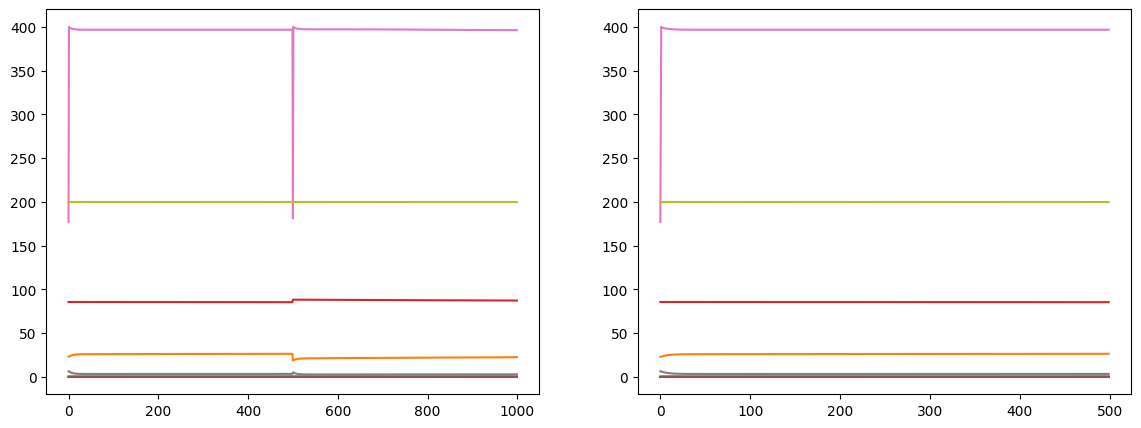

In [ ]:
t0 = pd.read_csv('../data/tests/2023_08_19_150212/toy_mRNA_circuit_10622_RNA_0_m5-9/signal_data.csv', header=None)
t1 = pd.read_csv('../data/tests/2023_08_19_150212/toy_mRNA_circuit_10622_RNA_0_m5-9_ref_circuit/signal_data.csv', header=None)
# t0 = pd.read_csv('../data/tests/2023_08_16_103714/toy_mRNA_circuit_12416_RNA_2_m15-3/signal_data.csv', header=None)

plt.figure(figsize=(14, 5))
ax = plt.subplot(1,2,1)
plt.plot(t0)
ax = plt.subplot(1,2,2)
plt.plot(t1)

In [ ]:

sdata0[sdata0['Subname'] == 'ref_circuit'][f'Sensitivity species-{t}'].min()

0.00030678182

In [ ]:
sdata0[f'Sensitivity species-{t}'] >= sdata0[sdata0['Subname'] == 'ref_circuit'][f'Sensitivity species-{t}'].min()

0     True
1     True
2     True
3     True
4     True
      ... 
65    True
66    True
67    True
68    True
69    True
Name: Sensitivity species-RNA_1, Length: 70, dtype: bool

In [ ]:
sdata1[sdata1['Next selected']]

,Name,Subname,Circuit Obj,Sensitivity species-RNA_1,Precision species-RNA_1,Overshoot species-RNA_1,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,...,Sensitivity species-RNA_2,Precision species-RNA_2,Overshoot species-RNA_2,Parent Sensitivity species-RNA_2,Parent Precision species-RNA_2,dS species-RNA_2,dP species-RNA_2,Diag Distance species-RNA_2,SP Prod species-RNA_2,Next selected
21,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
22,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,RNA_0_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
23,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,RNA_0_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
24,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,RNA_1_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
25,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,RNA_1_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
26,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,RNA_2_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
27,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_1_m1-1,RNA_2_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.000293,4194.23000,0.008102,0.000293,4194.23000,0.0,0.0,...,0.000291,4739.9463,0.010529,0.000291,4739.9463,0.0,0.0,4736.926591,2.662373e+07,True
35,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_0_m1-1,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.358209,3.19806,0.259839,0.358209,3.19806,0.0,0.0,...,0.000280,5080.8540,0.011963,0.000280,5080.8540,0.0,0.0,5077.834291,2.745768e+07,True
40,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_0_m1-1,RNA_2_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.358209,3.19806,0.259839,0.358209,3.19806,0.0,0.0,...,0.000280,5080.8540,0.011963,0.000280,5080.8540,0.0,0.0,5077.834291,2.745768e+07,True
41,toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_0_m1-1,RNA_2_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.358209,3.19806,0.259839,0.358209,3.19806,0.0,0.0,...,0.000280,5080.8540,0.011963,0.000280,5080.8540,0.0,0.0,5077.834291,2.745768e+07,True


### Process mutations between runs

In [34]:
def get_mutated_sequences(path, circ_row, mutation_type_mapping) -> dict:
    
    if not os.path.isfile(path):
        path = os.path.join(root_dir, path)
        assert os.path.isfile(path), f'Path {path} is not valid.'
    
    if circ_row['mutation_name'] == 'ref_circuit': 
        return path

    sequences = load_seq_from_FASTA(path, as_type = 'dict')
    mutated_species = circ_row['mutation_name'][:5]
    mutation_types = jax.tree_util.tree_map(lambda x: mutation_type_mapping[x], circ_row['mutation_type'])
    mutated_sequence = apply_mutation_to_sequence(
        sequences[mutated_species], circ_row['mutation_positions'], mutation_types)
    
    sequences[mutated_species] = mutated_sequence
    return sequences

    
def process_for_next_run(circuits: list, data_writer: DataWriter):
    
    for i, c in enumerate(circuits):
        circuits[i].name = make_next_name(c.name, c.subname)
        # sequences = {s.name: s.physical_data for s in c.model.species if s.physical_data}
        sequences = load_seq_from_FASTA(c.data.source, as_type='dict')
        circuits[i].data.source = write_mutated_circuit(
            name=circuits[i].name, subname='ref_circuit', sequences=sequences, data_writer=data_writer)
    return circuits
    
    
def write_mutated_circuit(
    name: str, subname: str, sequences, data_writer: DataWriter):
    
    data_writer.subdivide_writing(name)
    if subname != 'ref_circuit':
        data_writer.subdivide_writing(subname, safe_dir_change=False)
    
    new_path = data_writer.output(
        out_name=name,
        out_type='fasta', return_path=True,
        data=sequences, byseq=True
    )
    
    data_writer.unsubdivide()
    return new_path


def make_starting_circuits(starting_circuits: pd.DataFrame, config: dict, data_writer):
    d = {v: v for v in jax.tree_util.tree_flatten(get_mutation_type_mapping('RNA'))[0]}
    mutation_type_mapping_rev = jax.tree_util.tree_map(lambda x: reverse_mut_mapping(x), d)

    circuits = []
    for i, circ_row in starting_circuits.iterrows():
        curr_config = config
        sequences = get_mutated_sequences(circ_row['path_to_template_circuit'], circ_row, mutation_type_mapping_rev)
        path = write_mutated_circuit(
            name=circ_row['circuit_name'],
            subname=circ_row['mutation_name'],
            sequences=sequences,
            data_writer=data_writer)
        curr_config['data_path'] = path
        curr_config['interactions_loaded'] = None
        curr_config['interactions'] = None
        circuit = construct_circuit_from_cfg(prev_configs=None, config_file=curr_config) 
        circuit.name = make_next_name(circ_row['circuit_name'], circ_row['mutation_name'])
        circuits.append(circuit)
        
    return circuits


## Start loop

In [35]:
assert ('gpu' in str(jax.devices())) or ('GPU' in str(jax.devices())), 'Maybe use a GPU'

### Initialise starting circuits

In [36]:
target_species = ['RNA_1', 'RNA_2']
choose_max = 13
total_steps = 3

starting = make_starting_circuits(starting_circ_rows.iloc[:choose_max], config, data_writer)
# og_starting = simulate(og_starting, modeller, config)

### Run MC sim

In [37]:

distance_func = make_distance_func(data)

summary = {}
summary_batch = {}
summary_datas = {}
summary[0] = starting
for step in range(total_steps):
    
    print(f'\n\nStarting batch {step+1} out of {total_steps}\n\n')

    batch = mutate(starting, evolver, algorithm='random')
    batch = simulate(batch, modeller, config)
    expanded_batchs = []
    for b in batch:
        config['data_path'] = b.data.source
        expanded_batchs.append(load_circuit(
            os.path.join(data_writer.top_write_dir, b.name), 
            name=b.name, config=config, load_mutations_as_circuits=True))
    expanded_batchs = flatten_listlike(expanded_batchs, safe=True)
    starting, summary_data = choose_next(batch=expanded_batchs, data_writer=data_writer, distance_func=distance_func, 
                                         choose_max=choose_max, target_species=target_species, dist_weight=0.01)
    starting = process_for_next_run(starting, data_writer=data_writer)
    
    summary[step+1] = starting
    summary_batch[step] = expanded_batchs
    summary_datas[step] = summary_data
    
    for i in range(len(starting)):
        starting[i].subname = 'ref_circuit'

circuit_manager.py:batch_circuits():604: 	From 13 circuits, a total of 91 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():611: 		Starting new round of viable circuits (0 - 13 / 13) WARNING
circuit_manager.py:batch_circuits():629: 		Making subcircuits 0 - 91 took 0.101657s WARNING
circuit_manager.py:batch_circuits():635: 	Batching 0 - 20000 circuits (out of 0 - 91 (total: 91)) (Circuits: 0 - 13 of 13) WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11726_RNA_0_m3-8: compute_interactions WARNING




Starting batch 1 out of 3




circuit_manager.py:run_batch():702: 		Method compute_interactions took 9.374741s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11726_RNA_0_m3-8: init_circuits WARNING


Steady states:  100  iterations.  151  left to steady out.  0:00:23.342207
Steady states:  200  iterations.  4  left to steady out.  0:00:46.492623


circuit_manager.py:run_batch():702: 		Method init_circuits took 69.723553s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11726_RNA_0_m3-8: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():525: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:01:09.581088


circuit_manager.py:simulate_signal_batch():336: 		Simulating signal took 22.214528s WARNING


Done:  0:00:22.184530


circuit_manager.py:simulate_signal_batch():392: 		Calculating analytics took 5.689152s WARNING
circuit_manager.py:run_batch():702: 		Method simulate_signal_batch took 28.314323s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11726_RNA_0_m3-8: write_results WARNING
circuit_manager.py:run_batch():702: 		Method write_results took 0.629158s WARNING
circuit_manager.py:batch_circuits():649: Single batch: 0:01:48.146196 
Projected time: 108.14619600000002s 
Total time: 0:01:48.146206 WARNING
circuit_manager.py:batch_circuits():604: 	From 13 circuits, a total of 91 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():611: 		Starting new round of viable circuits (0 - 13 / 13) WARNING
circuit_manager.py:batch_circuits():629: 		Making subcircuits 0 - 91 took 0.098051s WARNING
circuit_manager.py:batch_circuits():635: 	Batching 0 - 20000 circuits (out of 0 - 91 (total: 91)) (Circuits: 0 - 13 of 13) WARNING
circuit_manager.py:run_ba



Starting batch 2 out of 3




circuit_manager.py:run_batch():702: 		Method compute_interactions took 7.995546s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_0_m1-1: init_circuits WARNING


Steady states:  100  iterations.  89  left to steady out.  0:00:22.840734


circuit_manager.py:run_batch():702: 		Method init_circuits took 45.895921s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_0_m1-1: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():525: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:00:45.749318


circuit_manager.py:simulate_signal_batch():336: 		Simulating signal took 22.314488s WARNING


Done:  0:00:22.284257


circuit_manager.py:simulate_signal_batch():392: 		Calculating analytics took 5.517579s WARNING
circuit_manager.py:run_batch():702: 		Method simulate_signal_batch took 28.269618s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_0_m1-1: write_results WARNING
circuit_manager.py:run_batch():702: 		Method write_results took 0.563231s WARNING
circuit_manager.py:batch_circuits():649: Single batch: 0:01:22.825314 
Projected time: 82.825314s 
Total time: 0:01:22.825324 WARNING
circuit_manager.py:batch_circuits():604: 	From 13 circuits, a total of 91 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():611: 		Starting new round of viable circuits (0 - 13 / 13) WARNING
circuit_manager.py:batch_circuits():629: 		Making subcircuits 0 - 91 took 0.097881s WARNING
circuit_manager.py:batch_circuits():635: 	Batching 0 - 20000 circuits (out of 0 - 91 (total: 91)) (Circuits: 0 - 13 of 13) WARNING
circuit_manager.py:run_



Starting batch 3 out of 3




circuit_manager.py:run_batch():702: 		Method compute_interactions took 7.940855s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_2_m1-1_RNA_1_m1-0: init_circuits WARNING


Steady states:  100  iterations.  19  left to steady out.  0:00:23.117065


circuit_manager.py:run_batch():702: 		Method init_circuits took 46.01834s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_2_m1-1_RNA_1_m1-0: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():525: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:00:45.879747


circuit_manager.py:simulate_signal_batch():336: 		Simulating signal took 22.444213s WARNING


Done:  0:00:22.413507


circuit_manager.py:simulate_signal_batch():392: 		Calculating analytics took 5.627442s WARNING
circuit_manager.py:run_batch():702: 		Method simulate_signal_batch took 28.440595s WARNING
circuit_manager.py:run_batch():666: 		Running 91 Subcircuits - toy_mRNA_circuit_11088_RNA_1_m3-5_RNA_2_m1-1_RNA_1_m1-0: write_results WARNING
circuit_manager.py:run_batch():702: 		Method write_results took 0.559728s WARNING
circuit_manager.py:batch_circuits():649: Single batch: 0:01:23.060104 
Projected time: 83.060104s 
Total time: 0:01:23.060113 WARNING


## Visualise circuit trajectory


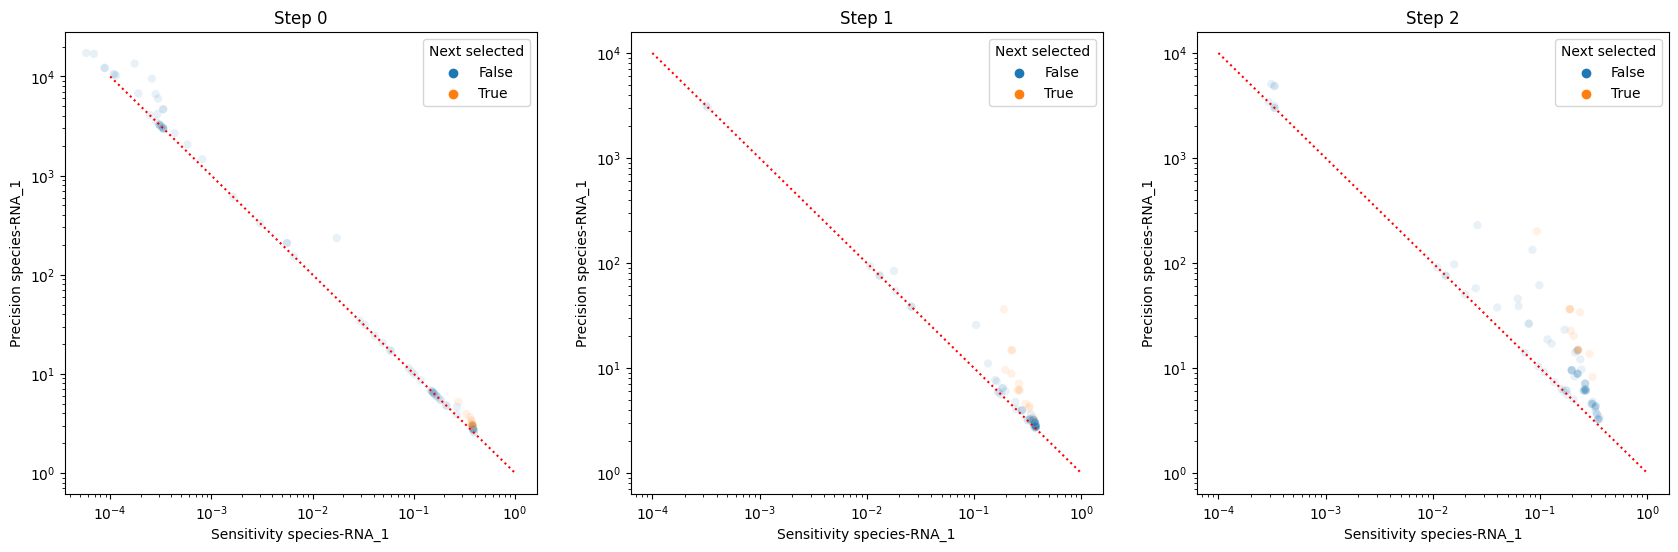

In [38]:

plt.figure(figsize=(len(summary) * 7, 6))
for step, sdata in summary_datas.items():
    ax = plt.subplot(1,len(summary), step+1)
    
    sns.scatterplot(sdata.sort_values(by=['Next selected']), x='Sensitivity species-RNA_1', y='Precision species-RNA_1', hue='Next selected', alpha=0.1)
    plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step}')

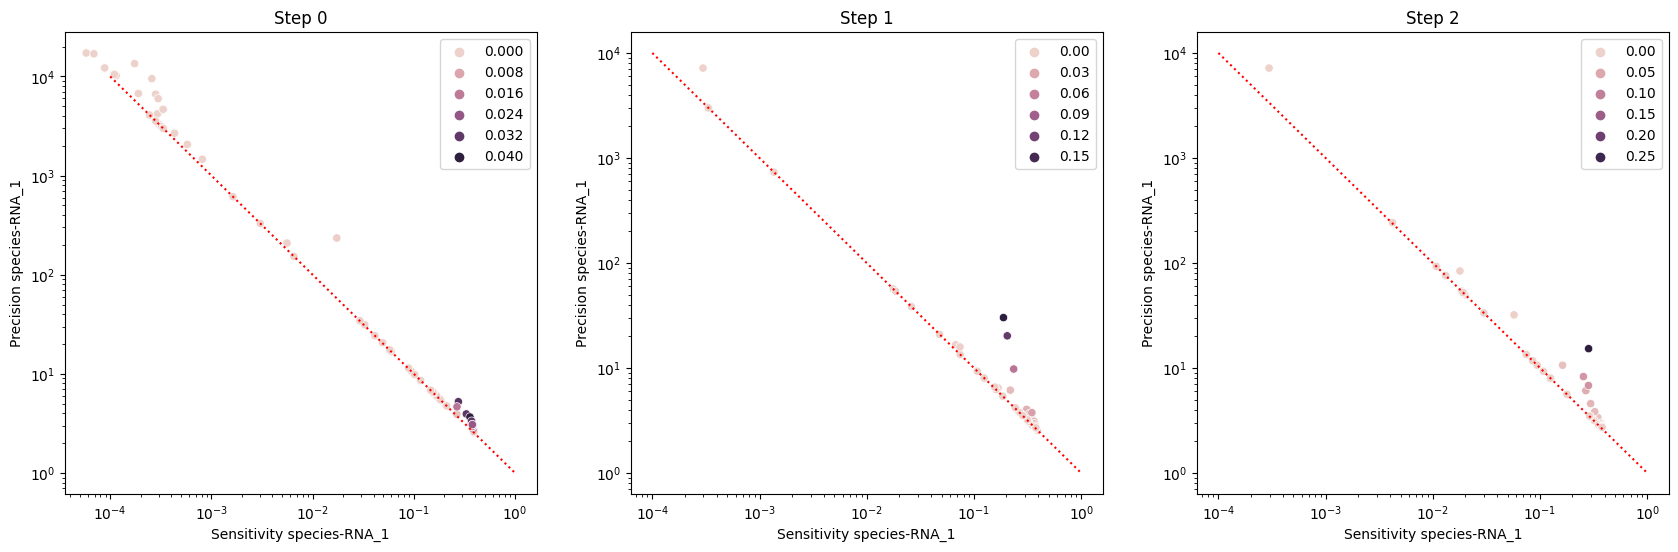

In [23]:

plt.figure(figsize=(len(summary) * 7, 6))
t = 'RNA_1'
for step, sdata in summary_datas.items():
    ax = plt.subplot(1,len(summary), step+1)
    
    # sns.scatterplot(sdata.sort_values(by=['Next selected']), x='Sensitivity species-RNA_1', y='Precision species-RNA_1', hue=f'SP and distance species-{t}', alpha=1)
    sns.scatterplot(sdata.sort_values(by=['Next selected']), x='Sensitivity species-RNA_1', y='Precision species-RNA_1', hue=sdata[f'SP Prod species-{t}'] * sdata[f'Log Distance species-{t}'], alpha=1)
    plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step}')

Text(0.5, 1.0, 'Step 2')

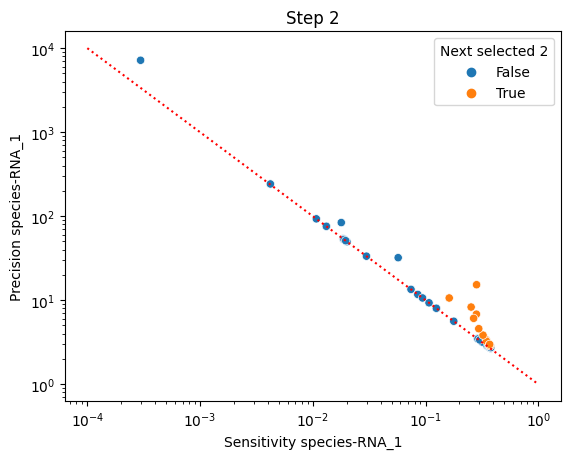

In [25]:
data_1 = summary_datas[2]

filt = (data_1[f'dS species-{t}'] >= 0) & (data_1[f'dP species-{t}'] >= 0) & (
    data_1[f'Sensitivity species-{t}'] >= data_1[data_1['Subname'] == 'ref_circuit'][f'Sensitivity species-{t}'].min()) & (
        data_1[f'Precision species-{t}'] >= data_1[data_1['Subname'] == 'ref_circuit'][f'Precision species-{t}'].min())

filt = (data_1[f'Sensitivity species-{t}'] >= data_1[data_1['Subname'] == 'ref_circuit'][f'Sensitivity species-{t}'].min()) & (
        data_1[f'Precision species-{t}'] >= data_1[data_1['Subname'] == 'ref_circuit'][f'Precision species-{t}'].min())

data_1['SP and distance'] = data_1[f'SP Prod species-{t}'] * data_1[f'Log Distance species-{t}']

circuits_chosen = data_1.sort_values(
    by=[f'SP and distance', f'Log Distance species-{t}', f'SP Prod species-{t}', 'Name', 'Subname'], ascending=False)['Circuit Obj'].iloc[:choose_max].to_list()

data_1['Next selected 2'] = data_1['Circuit Obj'].isin(circuits_chosen)

sns.scatterplot(data_1.sort_values(by=['Next selected 2']), x='Sensitivity species-RNA_1', y='Precision species-RNA_1', hue='Next selected 2', alpha=1)
plt.plot(np.logspace(-4, 0, 100), np.logspace(4, 0, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Step {step}')

In [ ]:
data_i = summary_datas[0]
data_f = summary_datas[1]

print(f'The improvement over {total_steps} cycles was:\n')
for t in ['RNA_1', 'RNA_2']:
    print(data_i[(data_i[f'dS species-{t}'] >= 0) & (data_i[f'dP species-{t}'] >= 0)].sort_values(by=[f'Sensitivity species-{t}', f'Precision species-{t}'], ascending=False)[[f'Sensitivity species-{t}', f'Precision species-{t}']].iloc[0] - \
        data_f[(data_f[f'dS species-{t}'] >= 0) & (data_f[f'dP species-{t}'] >= 0)].sort_values(by=[f'Sensitivity species-{t}', f'Precision species-{t}'], ascending=False)[[f'Sensitivity species-{t}', f'Precision species-{t}']].iloc[0])


The improvement over 3 cycles was:

Sensitivity species-RNA_1    0.006604
Precision species-RNA_1      0.137420
dtype: float64
Sensitivity species-RNA_2       0.409048
Precision species-RNA_2     -3199.001763
dtype: float64


In [ ]:
stop

NameError: name 'stop' is not defined

# Load prior experiment

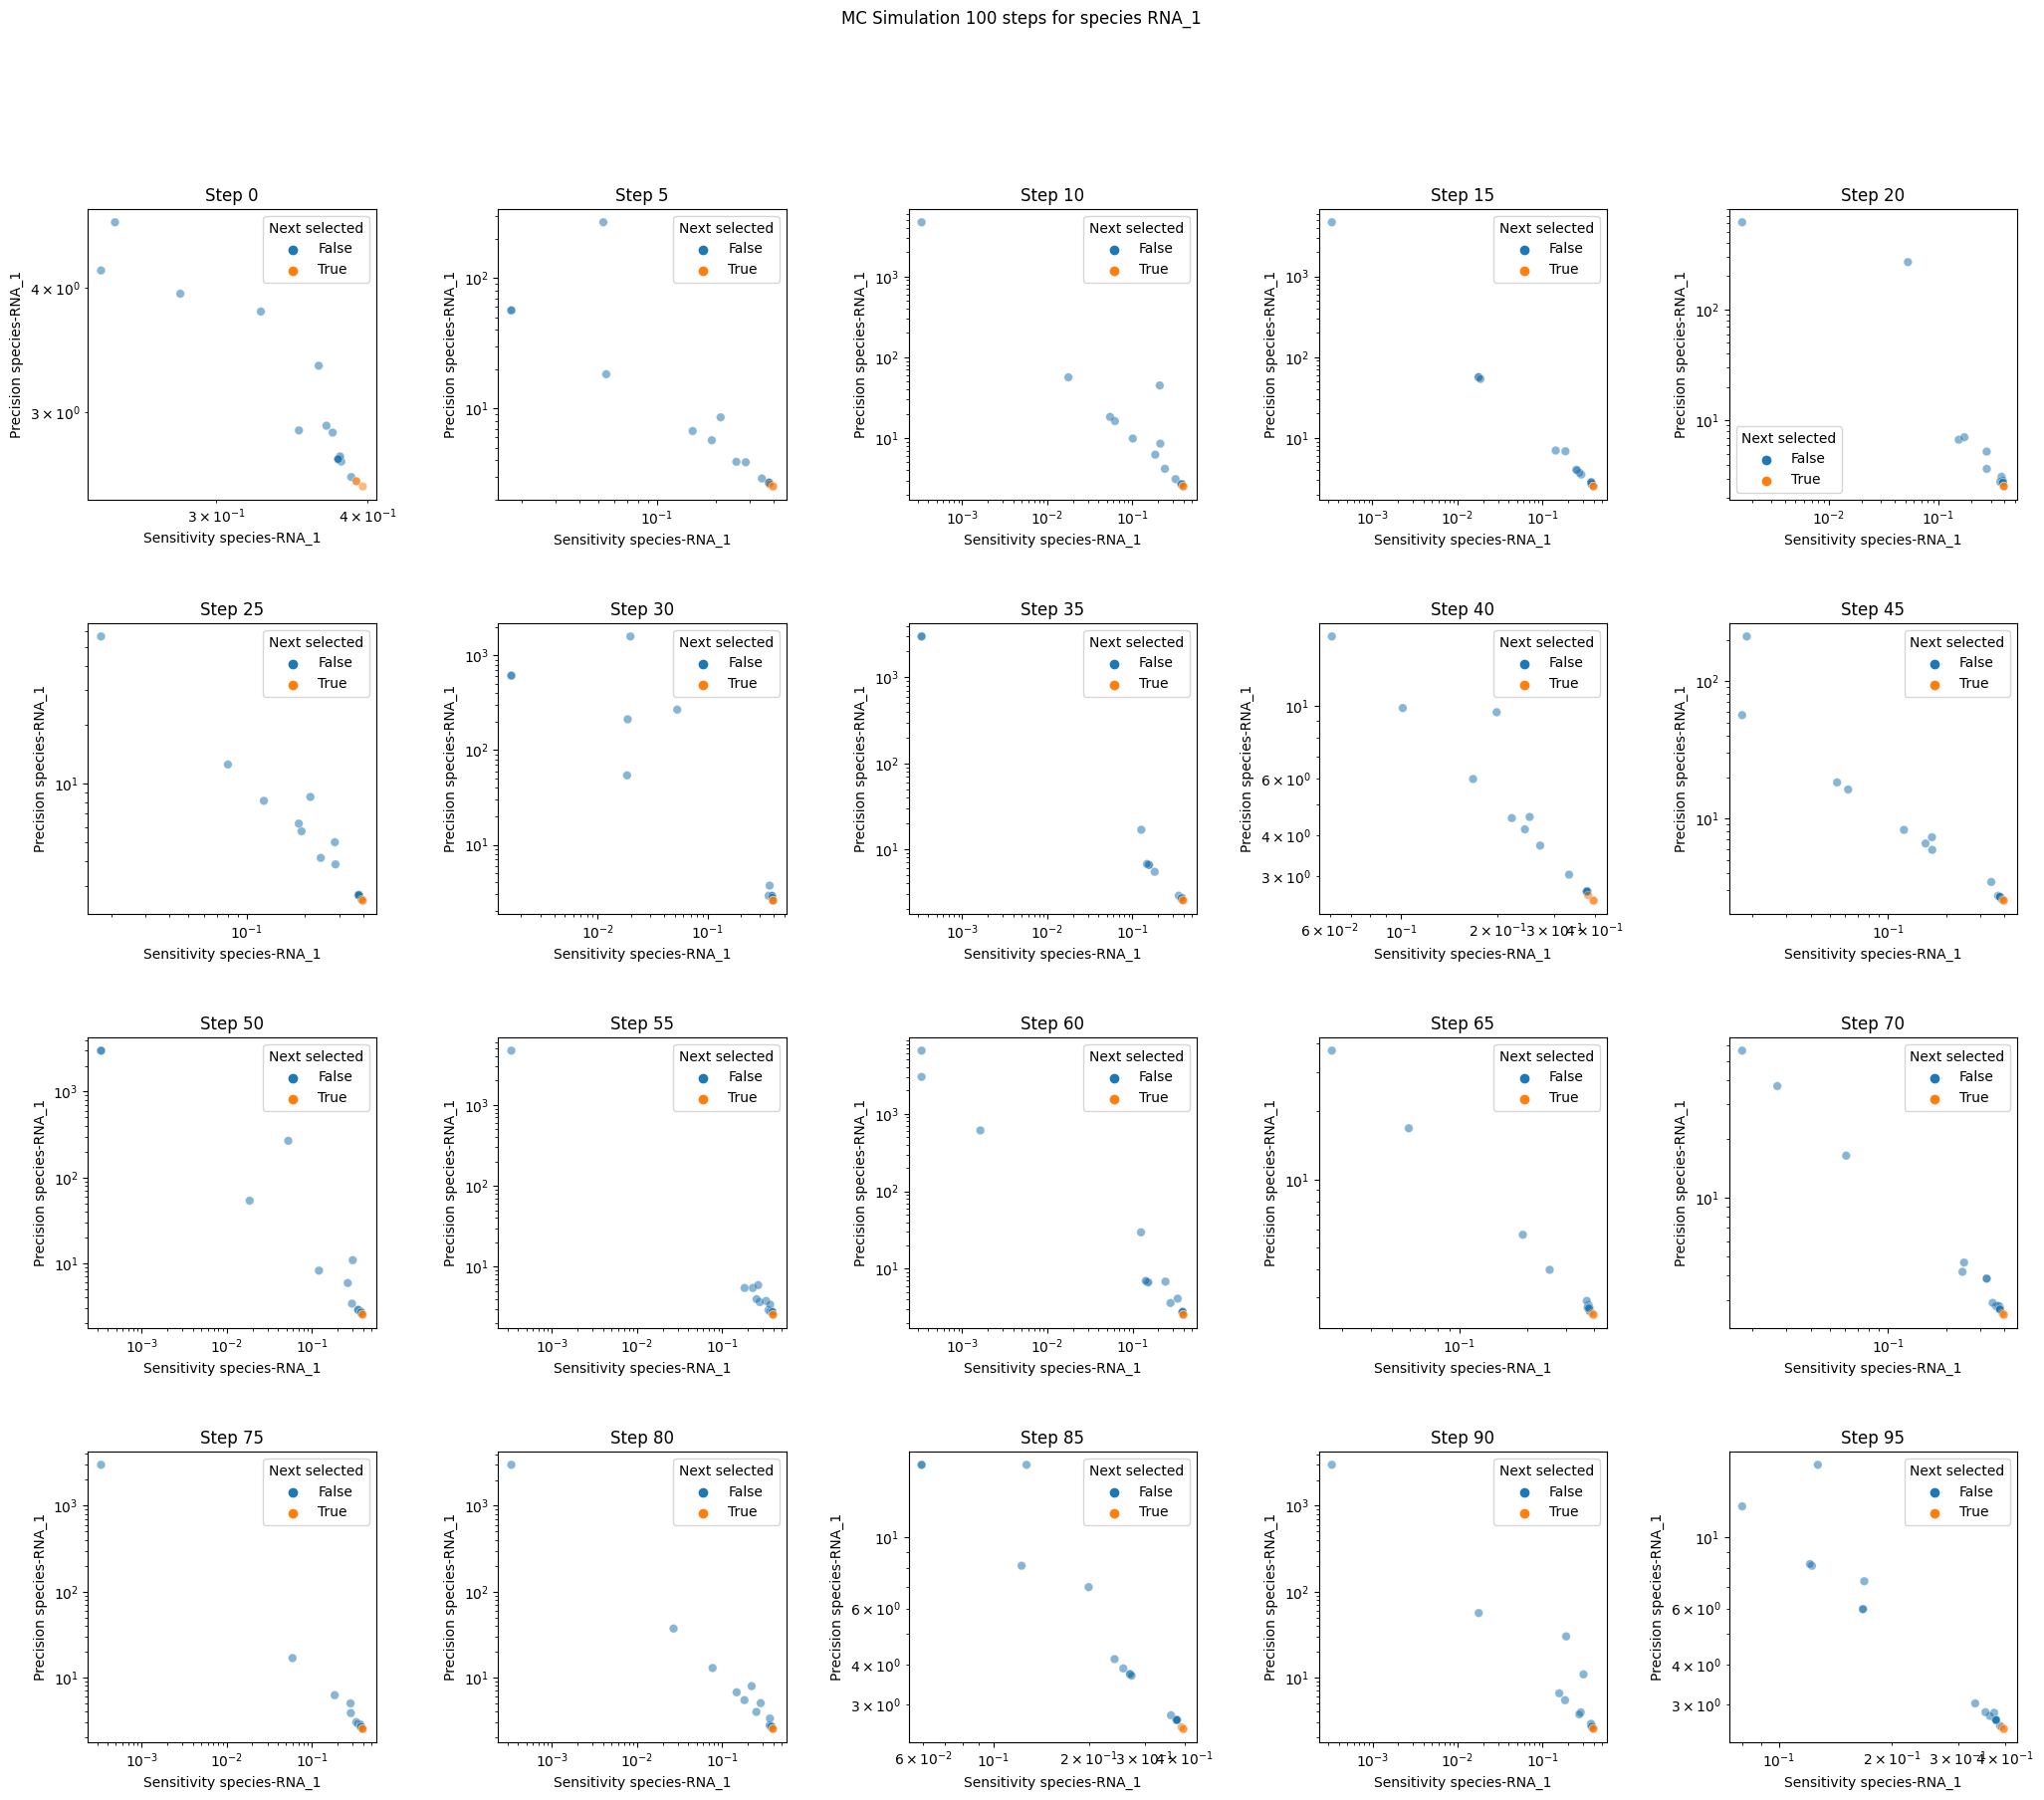

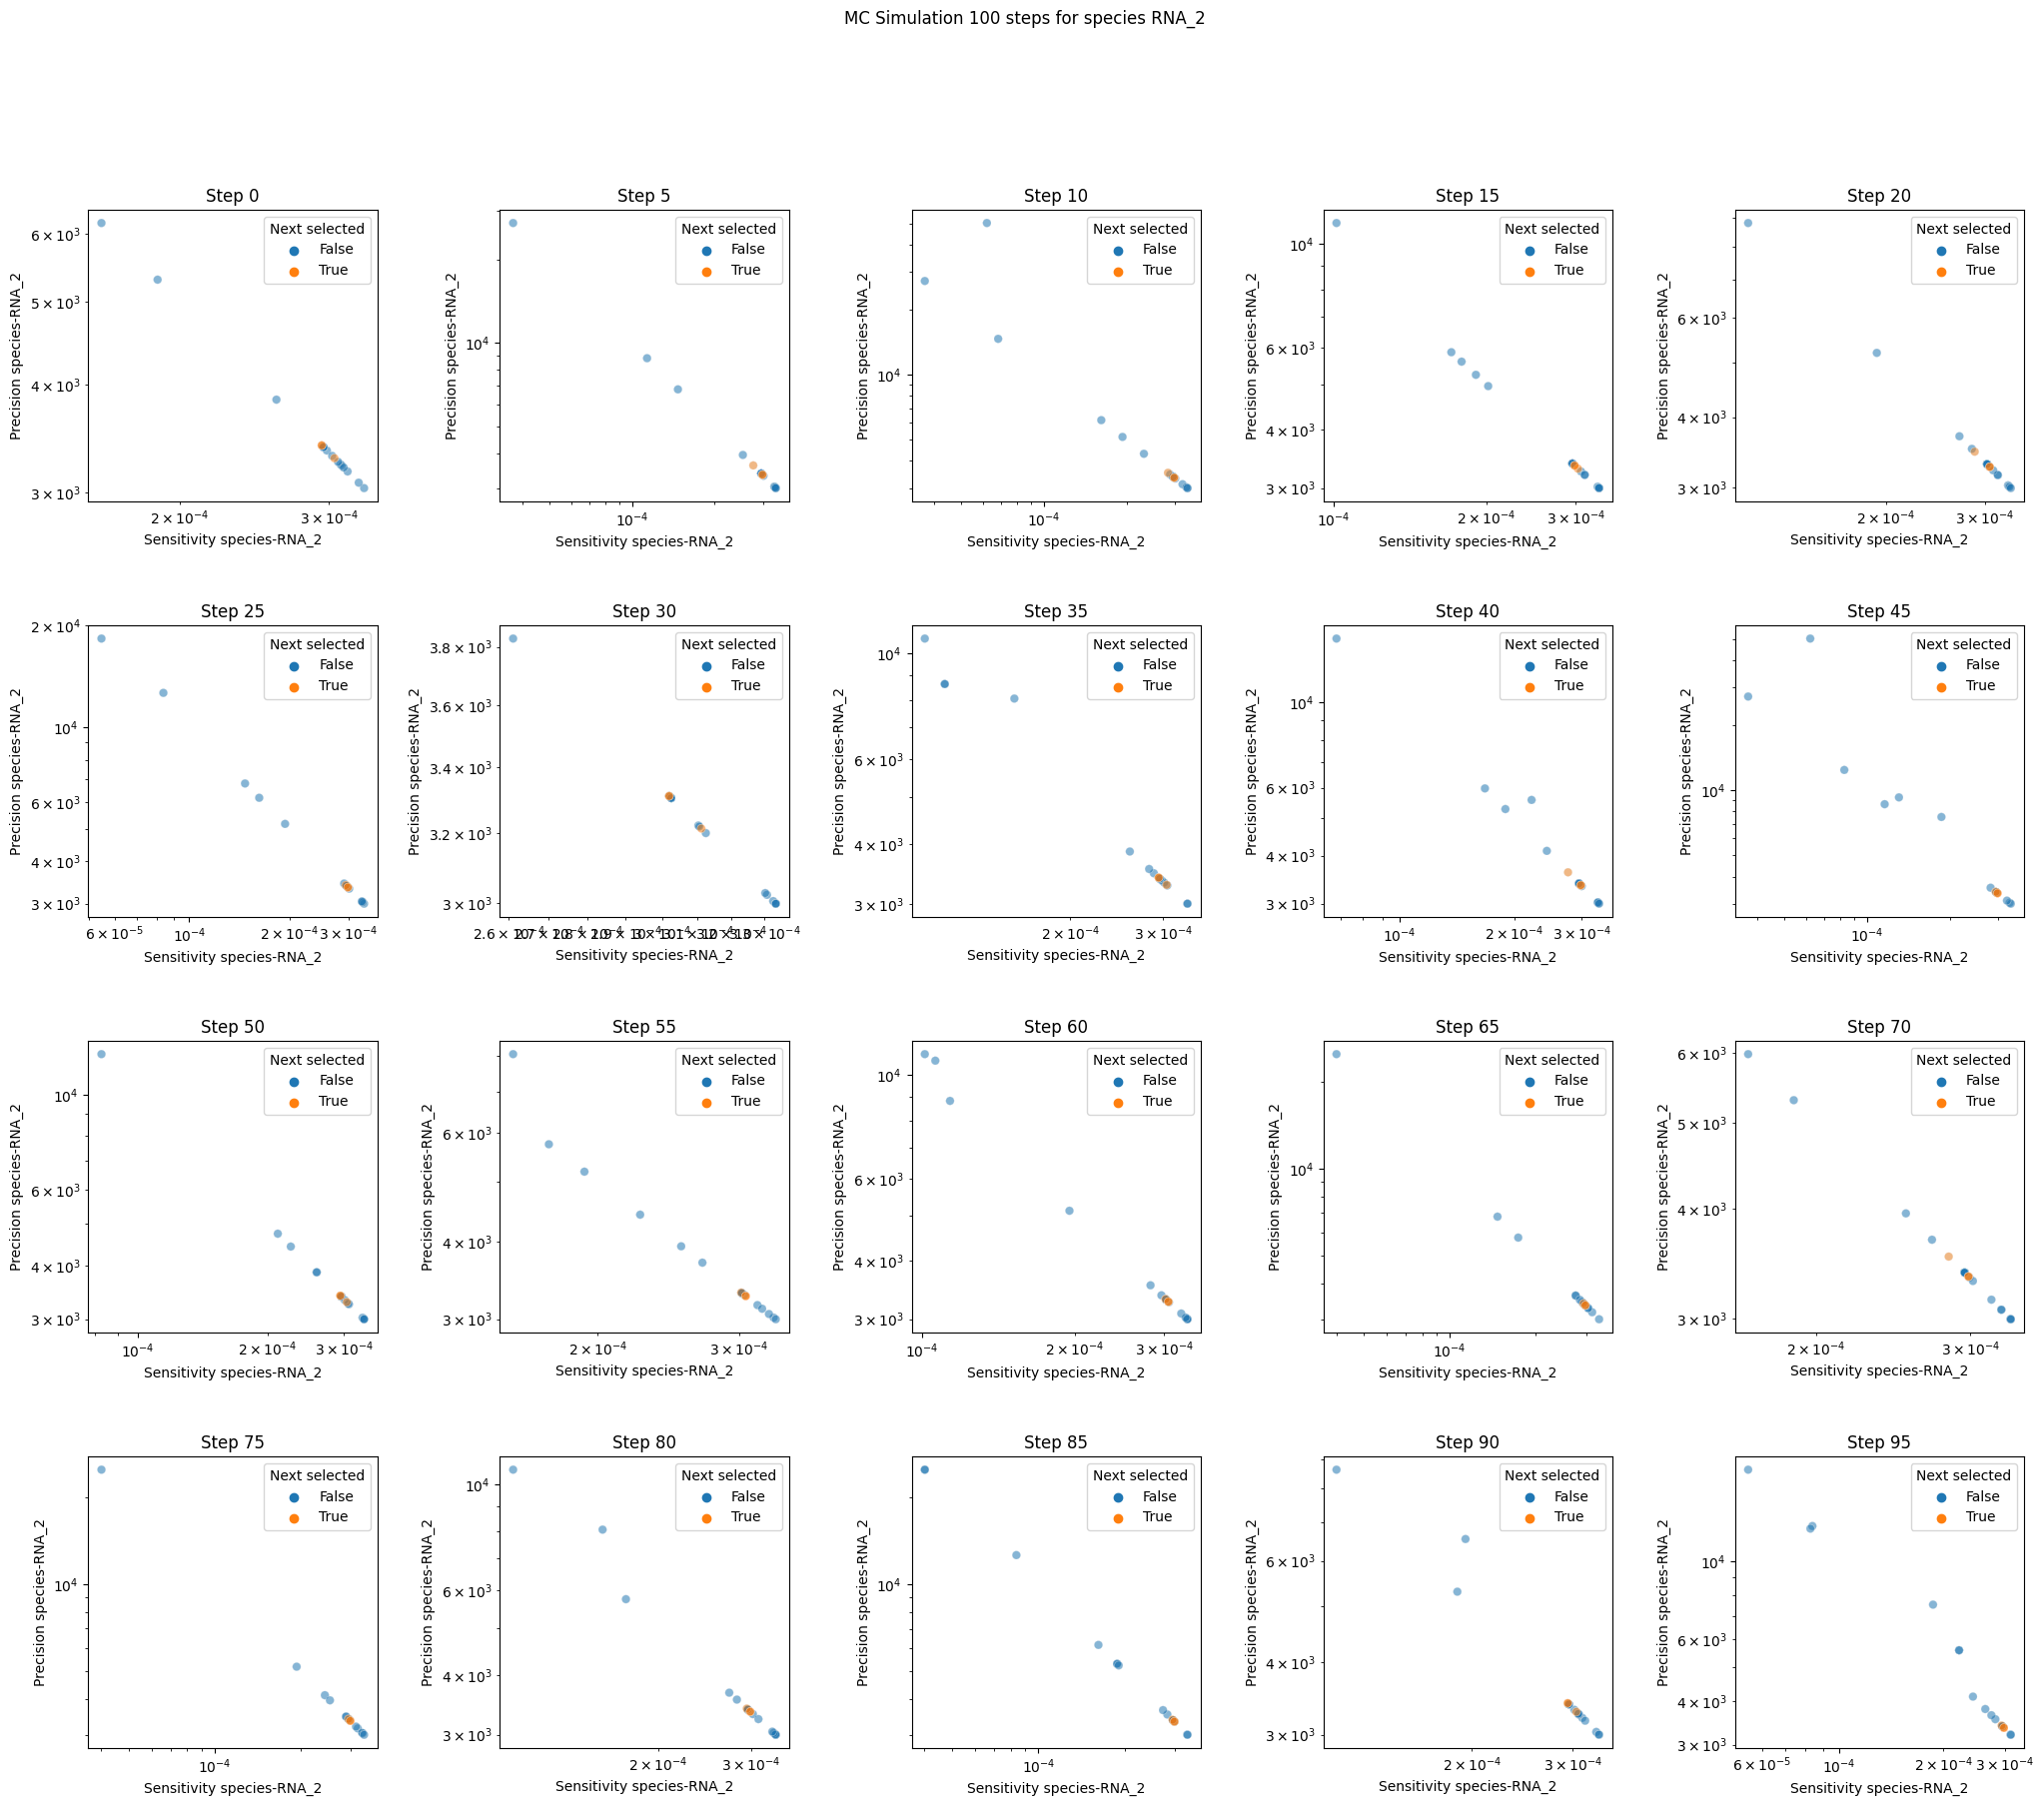

In [ ]:
datas_dir = '../data/mc_evolution/2023_08_14_225542/summary_datas'

n_steps = len(os.listdir(datas_dir))
skip_every = 5
n_plots = np.sum(np.mod(np.arange(n_steps), skip_every) == 0)
n_rows = int(np.sqrt(n_plots))
n_cols = int(np.ceil(np.sqrt(n_plots)))
for species in ['RNA_1', 'RNA_2']:

    fig = plt.figure(figsize=(5*n_cols, 5*n_rows))
    fig.subplots_adjust(hspace=0.425, wspace=0.425)
    for i, sdata_fn in enumerate(os.listdir(datas_dir)):
        if np.mod(i, skip_every) != 0:
            continue
        sdata = pd.read_csv(os.path.join(datas_dir, sdata_fn))
        ax = plt.subplot(n_rows, n_cols, int(i/skip_every)+1)
        
        sns.scatterplot(sdata.sort_values(by=['Next selected']), x=f'Sensitivity species-{species}', y=f'Precision species-{species}', hue='Next selected', alpha=0.1)
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Step {i}')
        
    plt.suptitle(f'MC Simulation {n_steps} steps for species {species}')

In [ ]:
print(f'Over {n_steps} steps, the improvement was the following')
improvements = pd.concat([
    pd.read_csv(os.path.join(datas_dir, os.listdir(datas_dir)[0])).sort_values(by=[f'Sensitivity species-{species}', f'Precision species-{species}'], ascending=False).iloc[[0]],
    pd.read_csv(os.path.join(datas_dir, os.listdir(datas_dir)[-1])).sort_values(by=[f'Sensitivity species-{species}', f'Precision species-{species}'], ascending=False).iloc[[0]]])
og_cols = list(improvements.columns)
improvements['Step'] = [1, 100]
improvements = improvements[['Step'] + og_cols]
improvements.drop(columns='Circuit Obj')


Over 100 steps, the improvement was the following


,Step,Name,Subname,Sensitivity species-RNA_1,Precision species-RNA_1,Sensitivity species-RNA_2,Precision species-RNA_2,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,Parent Sensitivity species-RNA_2,Parent Precision species-RNA_2,dS species-RNA_2,dP species-RNA_2,Next selected
119,1,toy_mRNA_circuit_10622_N_231713537538,ref_circuit,0.280063,3.948670,0.000330,3032.731,0.280063,3.948670,0.0,0.0,0.000330,3032.731,0.0,0.0,False
21,100,toy_mRNA_circuit_10622_N_013925855523,ref_circuit,0.077296,12.937266,0.000334,2998.082,0.077296,12.937266,0.0,0.0,0.000334,2998.082,0.0,0.0,False


In [ ]:
sdatas = pd.DataFrame()
for i, sdata_fn in enumerate(os.listdir(datas_dir)):
    sdata = pd.read_csv(os.path.join(datas_dir, sdata_fn))
    sdata['Step'] = i
    sdatas = pd.concat([sdatas, sdata[sdata['Next selected']]])

In [ ]:
sdatas

,Name,Subname,Circuit Obj,Sensitivity species-RNA_1,Precision species-RNA_1,Sensitivity species-RNA_2,Precision species-RNA_2,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,Parent Sensitivity species-RNA_2,Parent Precision species-RNA_2,dS species-RNA_2,dP species-RNA_2,Next selected,Step
0,toy_mRNA_circuit_10622_N_231713535397,ref_circuit,<synbio_morpher.utils.circuit.agnostic_circuit...,0.396422,2.522562,0.000304,3286.1120,0.396422,2.522562,0.0,0.0,0.000304,3286.1120,0.0,0.0,True,0
1,toy_mRNA_circuit_10622_N_231713535397,RNA_0_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.396422,2.522562,0.000304,3286.1120,0.396422,2.522562,0.0,0.0,0.000304,3286.1120,0.0,0.0,True,0
2,toy_mRNA_circuit_10622_N_231713535397,RNA_0_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.396422,2.522562,0.000304,3286.1120,0.396422,2.522562,0.0,0.0,0.000304,3286.1120,0.0,0.0,True,0
3,toy_mRNA_circuit_10622_N_231713535397,RNA_1_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.396422,2.522562,0.000304,3286.1120,0.396422,2.522562,0.0,0.0,0.000304,3286.1120,0.0,0.0,True,0
4,toy_mRNA_circuit_10622_N_231713535397,RNA_1_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.396422,2.522562,0.000304,3286.1120,0.396422,2.522562,0.0,0.0,0.000304,3286.1120,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,toy_mRNA_circuit_10622_N_013925856729,RNA_0_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.390539,2.560563,0.000283,3529.1904,0.390539,2.560563,0.0,0.0,0.000283,3529.1904,0.0,0.0,True,99
100,toy_mRNA_circuit_10622_N_013925856729,RNA_0_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.390539,2.560563,0.000283,3529.1904,0.390539,2.560563,0.0,0.0,0.000283,3529.1904,0.0,0.0,True,99
101,toy_mRNA_circuit_10622_N_013925856729,RNA_1_m1-0,<synbio_morpher.utils.circuit.agnostic_circuit...,0.390539,2.560563,0.000283,3529.1904,0.390539,2.560563,0.0,0.0,0.000283,3529.1904,0.0,0.0,True,99
102,toy_mRNA_circuit_10622_N_013925856729,RNA_1_m1-1,<synbio_morpher.utils.circuit.agnostic_circuit...,0.390539,2.560563,0.000283,3529.1904,0.390539,2.560563,0.0,0.0,0.000283,3529.1904,0.0,0.0,True,99


Text(0.5, 0.98, 'MC simulation')

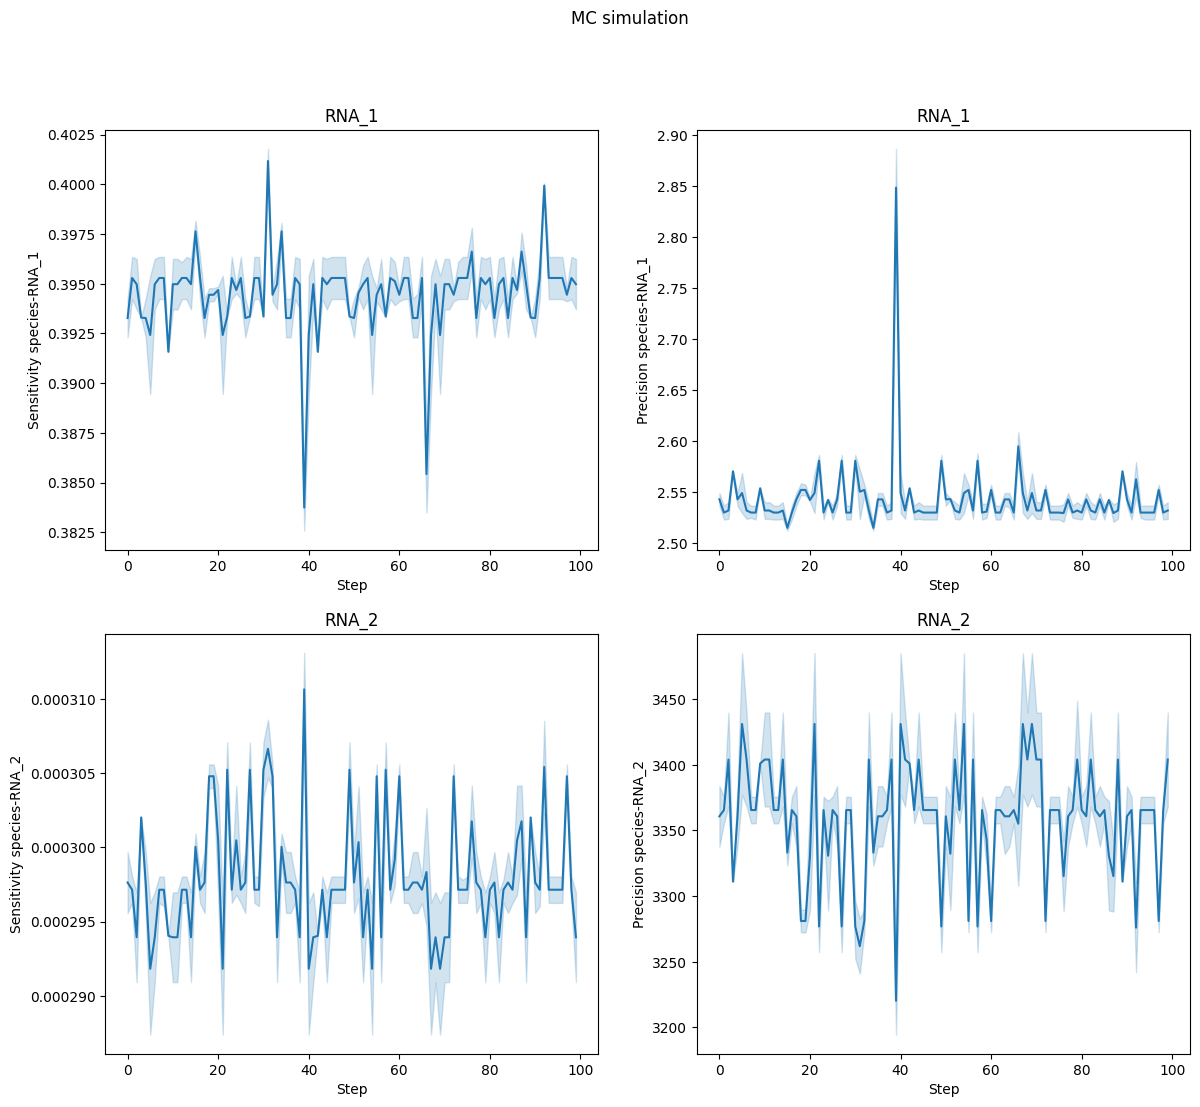

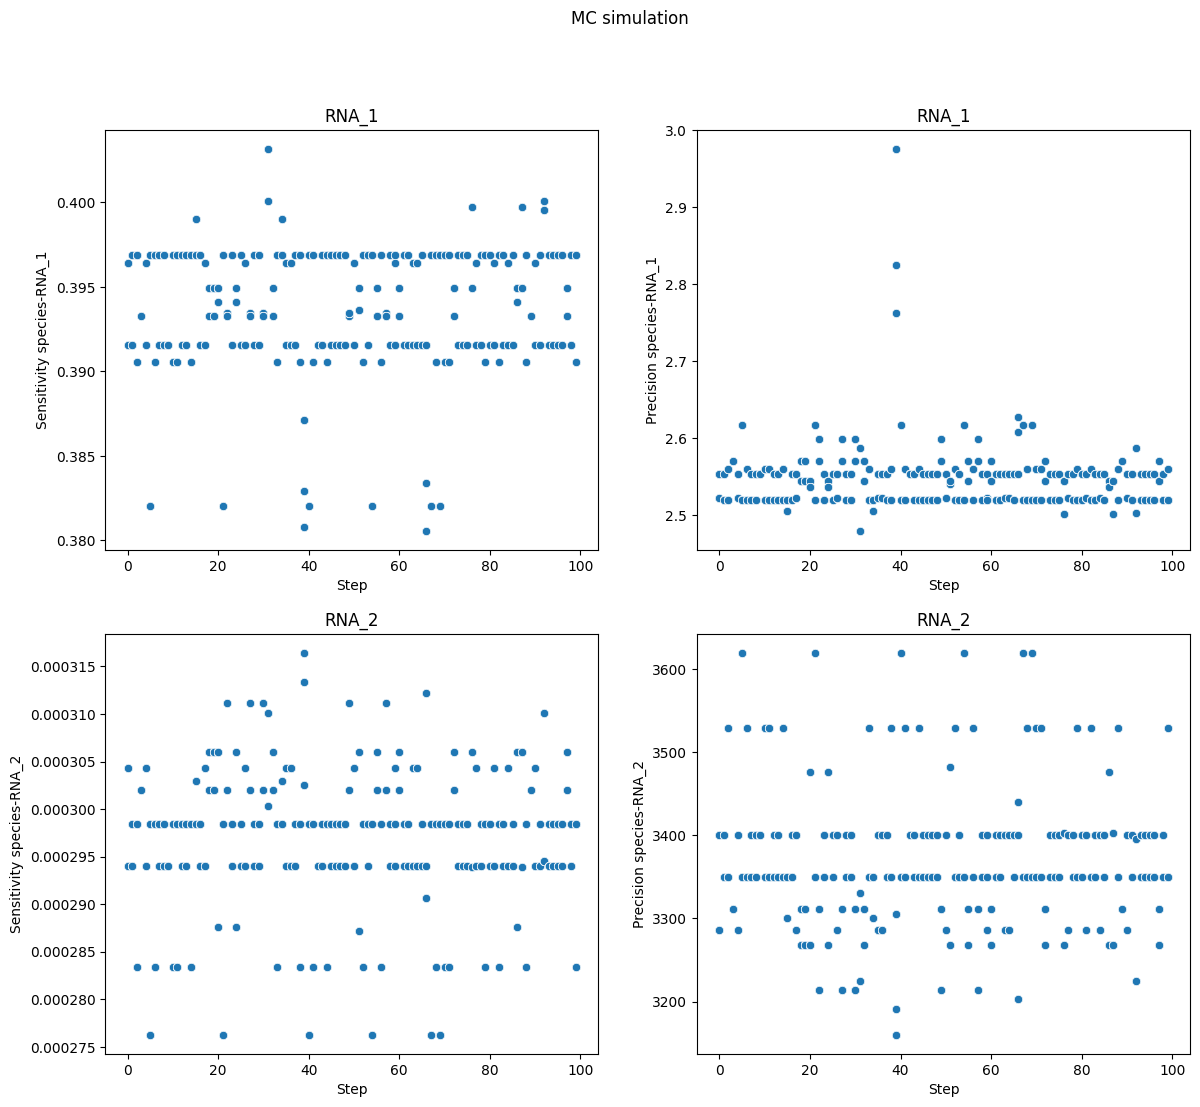

In [ ]:
fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(2,2,1)
species = 'RNA_1'
sns.lineplot(sdatas, x='Step', y=f'Sensitivity species-{species}')
plt.title(species)
ax = plt.subplot(2,2,2)
sns.lineplot(sdatas, x='Step', y=f'Precision species-{species}')
plt.title(species)
ax = plt.subplot(2,2,3)
species = 'RNA_2'
sns.lineplot(sdatas, x='Step', y=f'Sensitivity species-{species}')
plt.title(species)
ax = plt.subplot(2,2,4)
sns.lineplot(sdatas, x='Step', y=f'Precision species-{species}')
plt.title(species)

plt.suptitle('MC simulation')


fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(2,2,1)
species = 'RNA_1'
sns.scatterplot(sdatas, x='Step', y=f'Sensitivity species-{species}')
plt.title(species)
ax = plt.subplot(2,2,2)
sns.scatterplot(sdatas, x='Step', y=f'Precision species-{species}')
plt.title(species)
ax = plt.subplot(2,2,3)
species = 'RNA_2'
sns.scatterplot(sdatas, x='Step', y=f'Sensitivity species-{species}')
plt.title(species)
ax = plt.subplot(2,2,4)
sns.scatterplot(sdatas, x='Step', y=f'Precision species-{species}')
plt.title(species)

plt.suptitle('MC simulation')